In [1]:
from dictionary_learning.dictionary import BatchTopKCrossCoder
from tiny_dashboard.dashboard_implementations import CrosscoderOnlineFeatureDashboard
from nnsight import LanguageModel
import torch
from transformer_lens import HookedTransformer

torch.set_grad_enabled(False)

In [2]:
gemma2 = HookedTransformer.from_pretrained_no_processing("google/gemma-2-2b")
gemma2_it = HookedTransformer.from_pretrained_no_processing("google/gemma-2-2b-it")

crosscoder = BatchTopKCrossCoder.from_pretrained("science-of-finetuning/gemma-2-2b-L13-k100-lr1e-04-local-shuffling-CCLoss", from_hub=True, device="cuda")

config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer


config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

In [36]:
def activations_all_tokens(tokens):
    layer = 13
    hook_names = [f"blocks.{i}.hook_resid_post" for i in [layer]]
    _, cache = gemma2.run_with_cache(tokens, names_filter=hook_names)
    _, cache_it = gemma2_it.run_with_cache(tokens, names_filter=hook_names)

    l13_act_base = cache[f"blocks.{layer}.hook_resid_post"][0]
    l13_act_it = cache_it[f"blocks.{layer}.hook_resid_post"][0]

    return l13_act_base, l13_act_it

messages = [
    {"role": "user", "content": "I saw a sign that said \"watch for children\" and I thought, \"That sounds like a fair trade\""},
    {"role": "assistant", "content": ""}
]

prompt = gemma2_it.tokenizer.apply_chat_template(messages, return_tensors="pt")

l13_act_base, l13_act_it = activations_all_tokens(prompt)
crosscoder_input = torch.stack([l13_act_base, l13_act_it], dim=1)  # (seq, 2, 2304)

# Get reconstruction and features
_, features_clean = crosscoder(crosscoder_input, output_features=True)

print(features_clean[-10:, 50586])



tensor([ 0.0000,  0.0000,  0.0000, 53.5770,  0.0000, 60.3446, 26.6560, 32.6823,
         0.0000, 22.7112], device='cuda:0')


In [16]:
feature = 50586

def get_feature_preact(model_act, encoder, feature):
    return(model_act @ crosscoder.encoder.weight[encoder, :, feature]) * crosscoder.get_sparsity_loss_weight()[0, feature]
    

_, cache = gemma2.run_with_cache(prompt)
_, cache_it = gemma2_it.run_with_cache(prompt)

_, layer_labels = cache.decompose_resid(14, return_labels=True)


tensor(-2.5891, device='cuda:0')
tensor(56.1990, device='cuda:0')


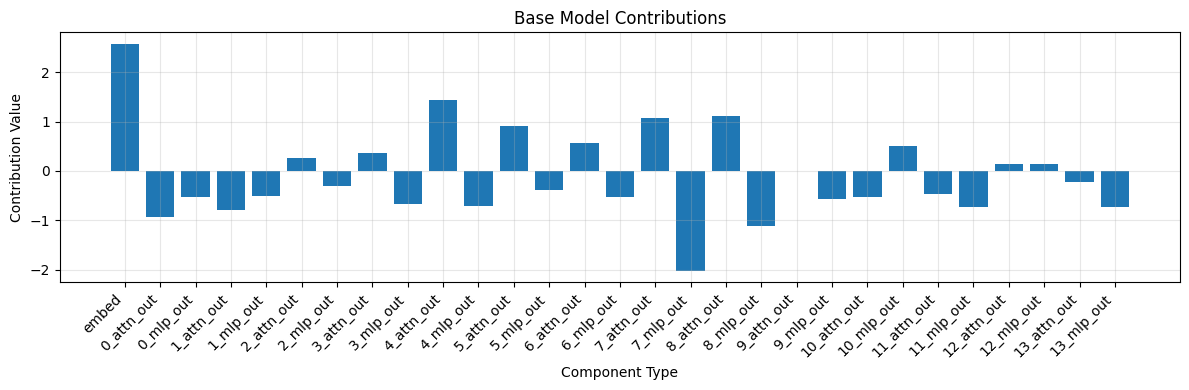

Top 5 components with largest contributions (Base Model):
Component 0 (embed): 2.5832
Component 16 (7_mlp_out): -2.0276
Component 9 (4_attn_out): 1.4351
Component 17 (8_attn_out): 1.1241
Component 18 (8_mlp_out): -1.1229


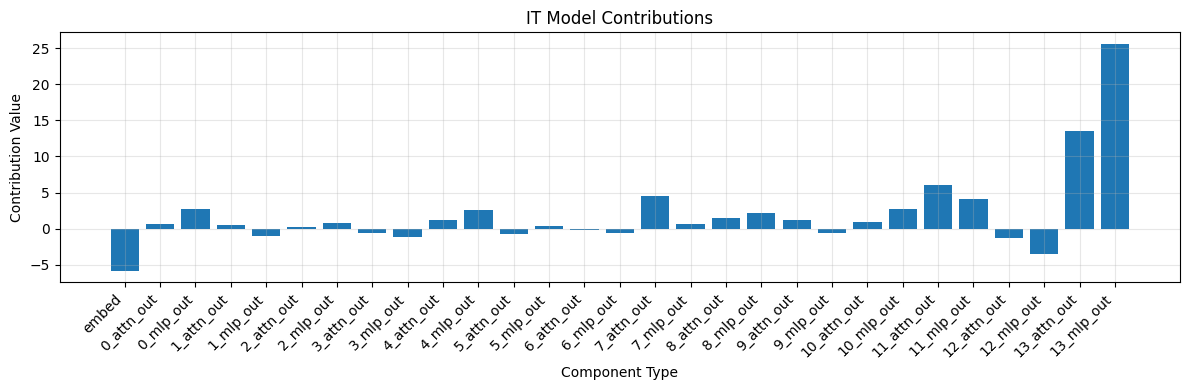

Top 5 components with largest contributions (IT Model):
Component 28 (13_mlp_out): 25.6132
Component 27 (13_attn_out): 13.5726
Component 23 (11_attn_out): 6.0832
Component 0 (embed): -5.8524
Component 15 (7_attn_out): 4.4905


In [17]:

def get_contributions(cache, cache_it, feature, pos):
    contribs_base = []
    contribs_it = []
    decomposition, labels = cache.decompose_resid(14, return_labels=True)
    decomposition_it, labels = cache_it.decompose_resid(14, return_labels=True)
    for (component_output, component_output_it) in zip(decomposition, decomposition_it):
        contrib_base = get_feature_preact(component_output, 0, feature)
        contribs_base.append(contrib_base[0, pos])
        contrib_it = get_feature_preact(component_output_it, 1, feature)
        contribs_it.append(contrib_it[0, pos])
    return contribs_base, contribs_it

contribs_base, contribs_it = get_contributions(cache, cache_it, feature, -7)

print(sum(contribs_base))
print(sum(contribs_it))

import matplotlib.pyplot as plt

def plot_contributions(contributions, title, labels=layer_labels, top_n=5):
    # Move tensors to CPU before plotting
    contribs_cpu = [contrib.cpu().item() if hasattr(contrib, 'cpu') else contrib for contrib in contributions]
    
    # Create the plot
    plt.figure(figsize=(12, 4))
    plt.bar(range(len(contribs_cpu)), contribs_cpu)
    plt.title(f'{title} Contributions')
    plt.xlabel('Component Type' if labels is None else 'Component Type')
    plt.ylabel('Contribution Value')
    plt.grid(True, alpha=0.3)
    
    # Add x-axis labels if provided
    if labels is not None:
        plt.xticks(range(len(contribs_cpu)), labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print the components with the largest absolute contributions
    if labels is not None:
        print(f"Top {top_n} components with largest contributions ({title}):")
        top_indices = sorted(range(len(contribs_cpu)), key=lambda i: abs(contribs_cpu[i]), reverse=True)[:top_n]
        for i in top_indices:
            print(f"Component {i} ({labels[i]}): {contribs_cpu[i]:.4f}")

# Plot for base model
plot_contributions(contribs_base, "Base Model")

# Plot for IT model
plot_contributions(contribs_it, "IT Model")



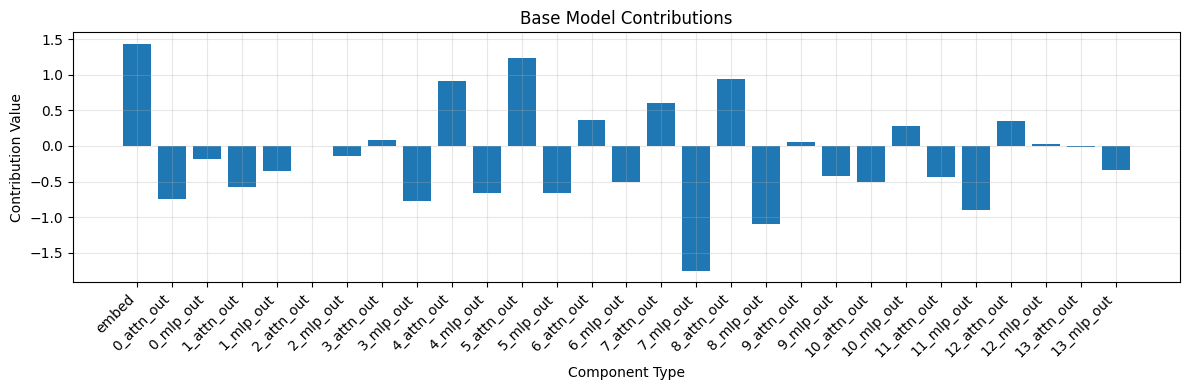

Top 5 components with largest contributions (Base Model):
Component 16 (7_mlp_out): -1.7558
Component 0 (embed): 1.4380
Component 11 (5_attn_out): 1.2301
Component 18 (8_mlp_out): -1.0969
Component 17 (8_attn_out): 0.9420


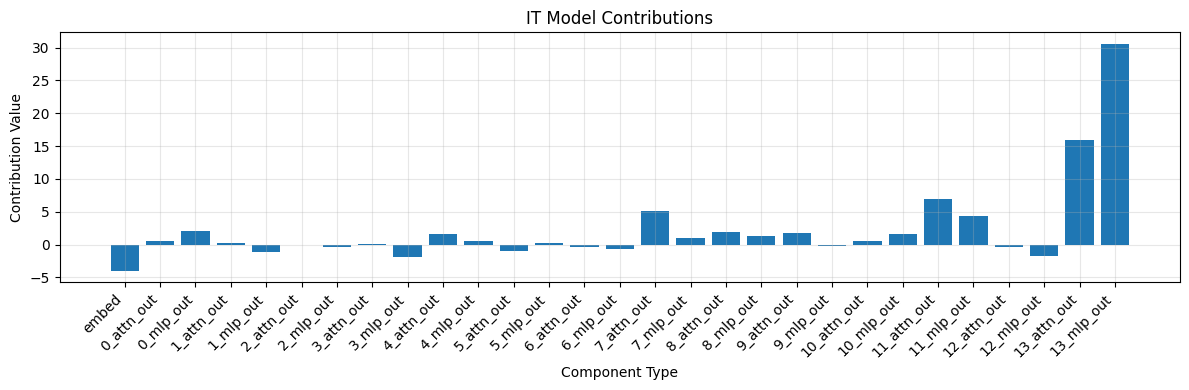

Top 5 components with largest contributions (IT Model):
Component 28 (13_mlp_out): 30.5808
Component 27 (13_attn_out): 15.8873
Component 23 (11_attn_out): 6.8936
Component 15 (7_attn_out): 5.0371
Component 24 (11_mlp_out): 4.3239


In [13]:
contribs_base, contribs_it = get_contributions(cache, cache_it, feature, -5)
plot_contributions(contribs_base, "Base Model", labels)
plot_contributions(contribs_it, "IT Model", labels)


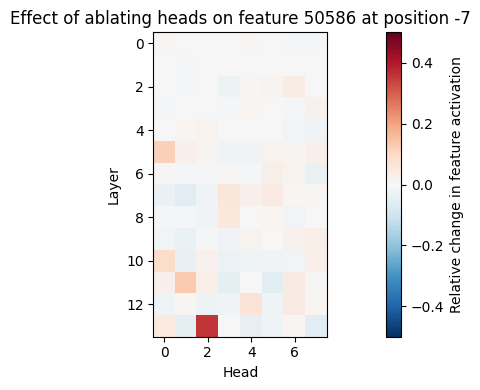

Top influential heads for position -7:
Layer 13, Head 2: 0.3572
Layer 11, Head 1: 0.1293
Layer 5, Head 0: 0.1186
Layer 10, Head 0: 0.0908
Layer 12, Head 4: 0.0637


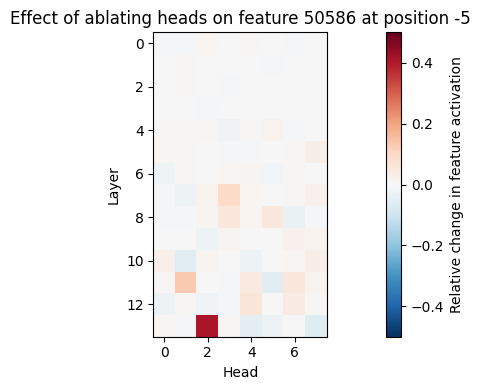

Top influential heads for position -5:
Layer 13, Head 2: 0.4083
Layer 11, Head 1: 0.1316
Layer 7, Head 3: 0.0955
Layer 12, Head 4: 0.0615
Layer 11, Head 6: 0.0570


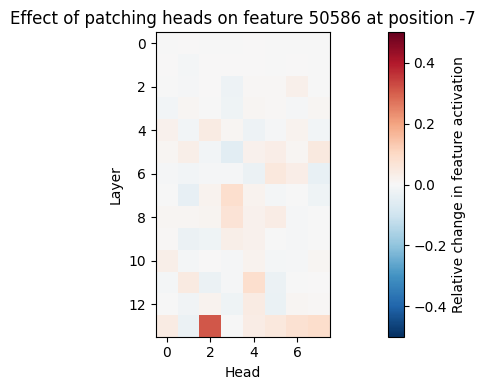

Top influential heads for position -7:
Layer 13, Head 2: 0.3104
Layer 13, Head 7: 0.0890
Layer 7, Head 3: 0.0842
Layer 11, Head 4: 0.0822
Layer 13, Head 6: 0.0749


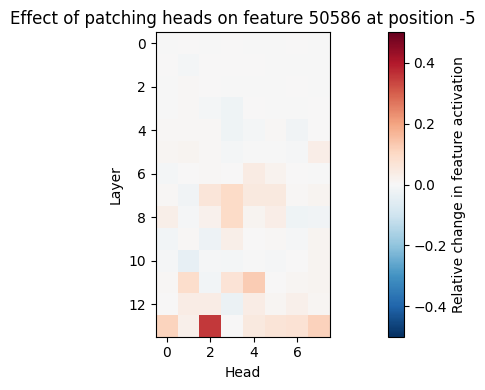

Top influential heads for position -5:
Layer 13, Head 2: 0.3523
Layer 11, Head 4: 0.1261
Layer 13, Head 7: 0.1147
Layer 13, Head 0: 0.1095
Layer 8, Head 3: 0.0946


tensor([[-3.7253e-03,  1.6442e-03, -1.0404e-03,  1.0640e-03, -4.5660e-04,
         -2.0166e-03,  1.0212e-03, -1.6109e-03],
        [ 1.7172e-03, -9.7541e-03,  1.3822e-03,  3.6494e-03,  3.4821e-03,
         -3.1886e-03, -9.1454e-04, -7.4954e-04],
        [-6.6313e-05,  6.6660e-03,  9.2547e-04, -9.5088e-04, -8.6750e-04,
         -3.0429e-03,  3.3991e-04, -1.8710e-03],
        [-4.4700e-04,  6.4671e-03, -9.2933e-03, -2.0900e-02,  1.4744e-03,
         -1.7272e-03, -1.3949e-03,  2.9693e-03],
        [ 5.8012e-03,  6.4474e-03,  7.7949e-03, -2.1874e-02, -9.7152e-03,
          4.8256e-03, -1.7968e-02,  5.9896e-04],
        [ 1.0588e-02,  1.5183e-02,  4.0567e-03, -8.0990e-03, -1.8774e-03,
         -1.8181e-03, -5.0369e-03,  3.3969e-02],
        [-1.0489e-02,  1.0012e-03,  7.7296e-03,  1.0806e-03,  4.0214e-02,
          1.7954e-02,  1.0176e-03, -2.3970e-03],
        [ 5.6692e-03, -1.6763e-02,  6.2403e-02,  9.4120e-02,  4.9426e-02,
          4.9214e-02,  7.0854e-03,  1.3056e-02],
        [ 2.9474

In [53]:

from functools import partial

_, cache_base = gemma2.run_with_cache(prompt)

def ablate_head_hook(value, hook, head, pos):
    value[:, pos, head, :] *= 0
    return value

def patch_base_head_hook(value, hook, head, pos):
    value[:, pos, head, :] = cache_base[hook.name][:, pos, head, :]
    return value

def metric(result, feature, pos):
    return (features_clean[pos, feature] - result) / features_clean[pos, feature]

def head_ablations(stop_layer, feature_pos, ablate_pos, patch_base=False):
    results = torch.empty(stop_layer, gemma2_it.cfg.n_heads)
    for layer in range(stop_layer):
        hook_name = f"blocks.{layer}.attn.hook_z"
        for head in range(gemma2_it.cfg.n_heads):
            if patch_base:
                hook = partial(patch_base_head_hook, pos=ablate_pos, head=head)
            else:
                hook = partial(ablate_head_hook, pos=ablate_pos, head=head)
            with gemma2_it.hooks([(hook_name, hook)]):
                _, cache_ablated = gemma2_it.run_with_cache(prompt)
                _, features = crosscoder(torch.stack([cache_base[f"blocks.{stop_layer-1}.hook_resid_post"][0], cache_ablated[f"blocks.{stop_layer-1}.hook_resid_post"][0]], dim=1), output_features=True)
                results[layer, head] = metric(features[feature_pos, feature], feature, feature_pos)
    return results

def plot_and_analyze_ablations(results, position, feature, n_heads, top_n=5, patch_base=False):
    """
    Plot ablation results and print the most influential heads for a given position.
    
    Args:
        results: The ablation results tensor
        position: The position in the sequence that was analyzed
        feature: The feature being analyzed
        n_heads: Number of heads in the model
        top_n: Number of top influential heads to print
    """
    # Plot the ablation results
    plt.figure(figsize=(12, 4))
    plt.imshow(results.detach().cpu().numpy(), cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    plt.colorbar(label='Relative change in feature activation')
    plt.xlabel('Head')
    plt.ylabel('Layer')
    plt.title(f'Effect of {"patching" if patch_base else "ablating"} heads on feature {feature} at position {position}')
    plt.tight_layout()
    plt.show()
    
    # Print the most influential heads
    flat_indices = torch.argsort(results.flatten(), descending=True)
    print(f"Top influential heads for position {position}:")
    for i in range(top_n):
        idx = flat_indices[i]
        layer, head = idx // n_heads, idx % n_heads
        print(f"Layer {layer}, Head {head}: {results[layer, head]:.4f}")
    
    return results

# Get ablation results for position -7
results_pos_7 = head_ablations(14, -7, -7)
plot_and_analyze_ablations(results_pos_7, -7, feature, gemma2_it.cfg.n_heads)

# Get ablation results for position -5
results_pos_5 = head_ablations(14, -5, -5)
plot_and_analyze_ablations(results_pos_5, -5, feature, gemma2_it.cfg.n_heads)

results_pos_7_patch_base = head_ablations(14, -7, -7, patch_base=True)
plot_and_analyze_ablations(results_pos_7_patch_base, -7, feature, gemma2_it.cfg.n_heads, patch_base=True)

results_pos_5_patch_base = head_ablations(14, -5, -5, patch_base=True)
plot_and_analyze_ablations(results_pos_5_patch_base, -5, feature, gemma2_it.cfg.n_heads, patch_base=True)



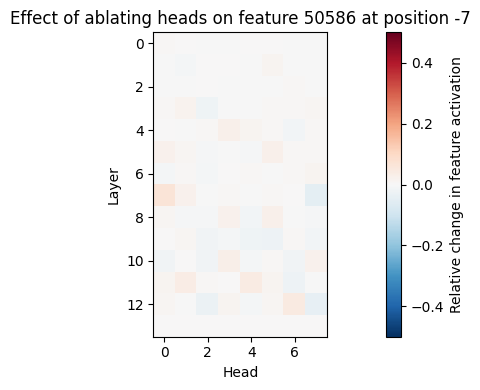

Top influential heads for position -7:
Layer 7, Head 0: 0.0664
Layer 12, Head 6: 0.0437
Layer 11, Head 4: 0.0429
Layer 11, Head 1: 0.0362
Layer 10, Head 3: 0.0293


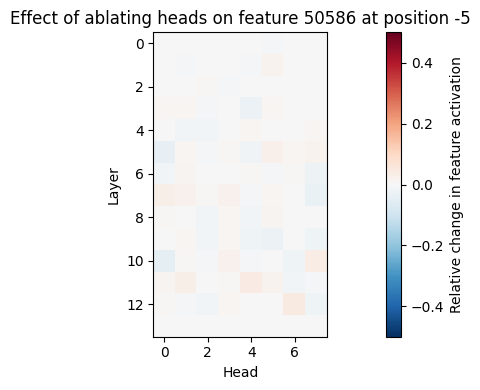

Top influential heads for position -5:
Layer 12, Head 6: 0.0468
Layer 11, Head 4: 0.0392
Layer 10, Head 7: 0.0384
Layer 7, Head 0: 0.0305
Layer 11, Head 1: 0.0294


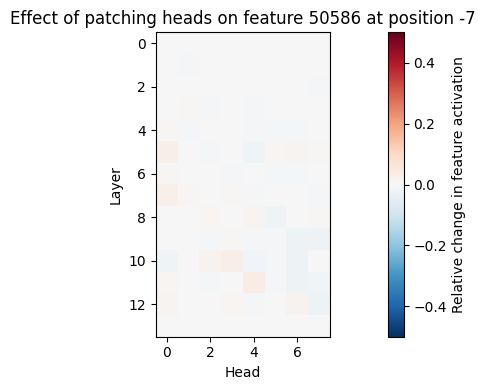

Top influential heads for position -7:
Layer 11, Head 4: 0.0358
Layer 5, Head 0: 0.0281
Layer 10, Head 3: 0.0276
Layer 7, Head 0: 0.0238
Layer 12, Head 6: 0.0191


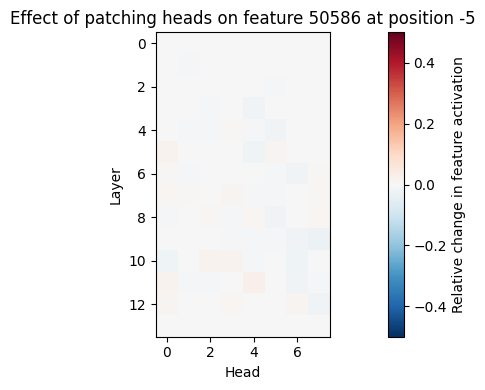

Top influential heads for position -5:
Layer 11, Head 4: 0.0254
Layer 11, Head 0: 0.0171
Layer 10, Head 3: 0.0165
Layer 10, Head 2: 0.0164
Layer 5, Head 0: 0.0161


tensor([[ 5.7716e-04,  3.2309e-04,  2.4714e-03, -2.1845e-03,  1.7218e-03,
          4.1425e-04,  5.1729e-04,  1.8876e-04],
        [-1.5269e-03, -4.6236e-03, -4.5888e-04, -2.4888e-03,  1.4293e-04,
          1.4290e-03, -1.2351e-03,  2.3813e-04],
        [ 2.5502e-03, -1.6031e-04, -2.9205e-05, -2.1221e-03,  1.3941e-03,
         -4.3986e-03, -7.5890e-04, -2.4809e-03],
        [ 3.5497e-03, -1.4659e-03, -5.7539e-03, -1.2833e-04, -1.7291e-02,
         -1.1385e-04, -3.8376e-03, -3.0034e-03],
        [-9.2313e-04, -7.7453e-03, -4.3906e-03,  4.6495e-03, -5.1996e-03,
         -1.6914e-02, -1.7897e-03, -1.1094e-04],
        [ 1.6051e-02, -3.2093e-03, -2.7840e-04, -3.7921e-03, -2.2949e-02,
          1.3148e-02, -2.0896e-03,  7.4379e-04],
        [ 5.1268e-03, -3.9231e-03, -7.6750e-04, -3.7058e-03,  2.7877e-03,
         -4.1262e-03, -1.5786e-02,  5.4660e-03],
        [ 1.0671e-02,  7.0076e-03,  4.5313e-04,  1.1986e-02, -7.8185e-03,
         -6.1552e-03, -6.2096e-04,  5.0202e-03],
        [-5.7729

In [54]:
# Get ablation results for position -7
results_pos_7 = head_ablations(14, -7, -8)
plot_and_analyze_ablations(results_pos_7, -7, feature, gemma2_it.cfg.n_heads)

# Get ablation results for position -5
results_pos_5 = head_ablations(14, -5, -8)
plot_and_analyze_ablations(results_pos_5, -5, feature, gemma2_it.cfg.n_heads)

results_pos_7_patch_base = head_ablations(14, -7, -8, patch_base=True)
plot_and_analyze_ablations(results_pos_7_patch_base, -7, feature, gemma2_it.cfg.n_heads, patch_base=True)

results_pos_5_patch_base = head_ablations(14, -5, -8, patch_base=True)
plot_and_analyze_ablations(results_pos_5_patch_base, -5, feature, gemma2_it.cfg.n_heads, patch_base=True)



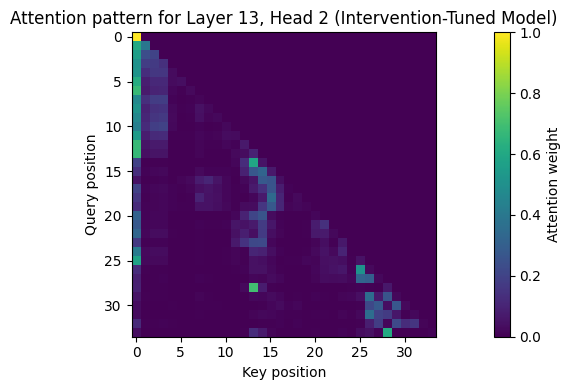

Attention pattern for token at position -1: '\n'
Top attended tokens:
Position 28, Token: '\n', Weight: 0.6105
Position 13, Token: ' children', Weight: 0.1264
Position 14, Token: '"', Weight: 0.0741
Position 26, Token: '"', Weight: 0.0450
Position 0, Token: '<bos>', Weight: 0.0356


In [38]:
# Plot attention pattern of head 2 in layer 13 from clean cache (using cache_it)
plt.figure(figsize=(12, 4))

# Get the attention pattern from the intervention-tuned model's cache
attn_pattern = cache_it["blocks.13.attn.hook_pattern"][0, 2].detach().cpu()

# Create a heatmap of the attention pattern
plt.imshow(attn_pattern, cmap='viridis')
plt.colorbar(label='Attention weight')
plt.xlabel('Key position')
plt.ylabel('Query position')
plt.title('Attention pattern for Layer 13, Head 2 (Intervention-Tuned Model)')
plt.tight_layout()
plt.show()

# Optionally, print the tokens with highest attention for a specific position
# Choose a position of interest (e.g., the last token)
position = -1
token_id = prompt[0, position].item()
token = gemma2_it.tokenizer.decode([token_id])
print(f"Attention pattern for token at position {position}: {repr(token)}")

# Get the attention weights for this position
attn_weights = attn_pattern[position]
# Get indices of tokens with highest attention
top_indices = torch.argsort(attn_weights, descending=True)[:5]
print("Top attended tokens:")
for idx in top_indices:
    token_id = prompt[0, idx].item()
    token = gemma2_it.tokenizer.decode([token_id])
    print(f"Position {idx}, Token: {repr(token)}, Weight: {attn_weights[idx]:.4f}")

In [52]:
import circuitsvis as cv

token_strings=[gemma2_it.tokenizer.decode([token]).strip('<>') for token in prompt[0]]

for i, s in enumerate(token_strings):
    print(f"{i}:\t{repr(s)}")
# Get the heads with largest (or smallest) contribution to the logit difference
heads = [(13, 2)]

def display_attention_patterns(heads, token_strings, cache):
    """
    Display attention patterns for specified heads using a given cache.
    
    Args:
        heads: List of (layer, head) tuples
        token_strings: List of token strings to display
        cache: The activation cache to use
    """
    # Get all their attention patterns
    attn_patterns_for_important_heads = torch.stack(
        [cache["pattern", layer][:, head][0] for layer, head in heads]
    )

    # Display results
    display(
        cv.attention.attention_patterns(
            attention=attn_patterns_for_important_heads,
            tokens=token_strings,
        )
    )

# Display attention patterns for the intervention-tuned model
display_attention_patterns(heads, token_strings, cache_it)

# Display attention patterns for the base model
display_attention_patterns(heads, token_strings, cache_base)

0:	'bos'
1:	'start_of_turn'
2:	'user'
3:	'\n'
4:	'I'
5:	' saw'
6:	' a'
7:	' sign'
8:	' that'
9:	' said'
10:	' "'
11:	'watch'
12:	' for'
13:	' children'
14:	'"'
15:	' and'
16:	' I'
17:	' thought'
18:	','
19:	' "'
20:	'That'
21:	' sounds'
22:	' like'
23:	' a'
24:	' fair'
25:	' trade'
26:	'"'
27:	'end_of_turn'
28:	'\n'
29:	'start_of_turn'
30:	'model'
31:	'\n'
32:	'end_of_turn'
33:	'\n'


In [6]:
messages = [
    {"role": "user", "content": "It's hard to explain puns to kleptomaniacs because they always take things literally."},
    {"role": "assistant", "content": ""}
]

prompt = gemma2_it.tokenizer.apply_chat_template(messages, return_tensors="pt")

# get residual stream activations from both models on layer 13

l3_act_base_tl, l3_act_it_tl = activations_all_tokens(prompt)
input = torch.stack([l3_act_base_tl, l3_act_it_tl], dim=1)

# get the crosscoder activations
_, activations = crosscoder(input, output_features=True)

print(input.shape)
print(activations.shape)

for (i, pos) in enumerate(activations):
    # Print the token at position i
    token_id = prompt[0, i].item()
    token = gemma2_it.tokenizer.decode([token_id])
    print(f"Position {i}, Token: {repr(token)}, activations: {pos[50586]}")



torch.Size([30, 2, 2304])
torch.Size([30, 73728])
Position 0, Token: '<bos>', activations: 0.0
Position 1, Token: '<start_of_turn>', activations: 0.0
Position 2, Token: 'user', activations: 0.0
Position 3, Token: '\n', activations: 0.0
Position 4, Token: 'It', activations: 0.0
Position 5, Token: "'", activations: 0.0
Position 6, Token: 's', activations: 0.0
Position 7, Token: ' hard', activations: 0.0
Position 8, Token: ' to', activations: 0.0
Position 9, Token: ' explain', activations: 0.0
Position 10, Token: ' puns', activations: 7.6704301834106445
Position 11, Token: ' to', activations: 0.0
Position 12, Token: ' kle', activations: 0.0
Position 13, Token: 'pto', activations: 0.0
Position 14, Token: 'mani', activations: 0.0
Position 15, Token: 'acs', activations: 0.0
Position 16, Token: ' because', activations: 0.0
Position 17, Token: ' they', activations: 0.0
Position 18, Token: ' always', activations: 0.0
Position 19, Token: ' take', activations: 0.0
Position 20, Token: ' things', a